# Basic Manipulation of Data

An example of basics manipulation of data using the COAsT package.

This is an introduction to the Gridded class. Loading variables and grid information. This is designed to be a brief introduction to the Gridded class including:

    1. Creation of a Gridded object
    2. Loading data into the Gridded object.
    3. Combining Gridded output and Gridded domain data.
    4. Interrogating the Gridded object.
    5. Basic manipulation and subsetting
    6. Looking at the data with matplotlib

### Loading and Interrogating

Begin by importing COAsT and define some file paths for NEMO output data and a NEMO domain, as an example of model data suitable for the Gridded object.

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import coast
import matplotlib.pyplot as plt
import datetime
import numpy as np

fn_nemo_dat = "/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/OCN/yearly/1950"
fn_nemo_dom = "/gws/nopw/j04/canari/users/dlrhodso/mesh_mask.nc"
fn_config_t_grid = "../config/example_nemo_grid_t.json"

/gws/smf/j04/canari/conda-env/lib/python3.10/site-packages/pydap/lib.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
/gws/smf/j04/canari/conda-env/lib/python3.10/site-packages/pkg_resources/__init__.py:2846: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydap')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
/gws/smf/j04/canari/conda-env/lib/python3.10/site-packages/pkg_resources/__init__.py:2846: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydap.responses')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
/gws/smf/j04/canari/conda-

We can create a new Gridded object by simple calling `coast.Gridded()`. By passing this a NEMO data file and a NEMO domain file, COAsT will combine the two into a single xarray dataset within the Gridded object. Each individual Gridded object should be for a specified NEMO grid type, which is specified in a configuration file which is also passed as an argument. The Dask library is switched on by default, chunking can be specified in the configuration file.

In [3]:
nemo_t = coast.Gridded(fn_data = f"{fn_nemo_dat}/cv575o_1_mon__grid_T_sossheig.nc", fn_domain = fn_nemo_dom, config=fn_config_t_grid)

Our new Gridded object `nemo_t` contains a variable called dataset, which holds information on the two files we passed. Let’s have a look at this:

In [4]:
nemo_t.dataset

<xarray.Dataset> Size: 2GB
Dimensions:              (t_dim: 12, axis_nbounds: 2, y_dim: 1207, x_dim: 1442,
                          nvertex: 4, z_dim: 75)
Coordinates:
  * time                 (t_dim) object 96B 1950-01-16 00:00:00 ... 1950-12-1...
  * y                    (y_dim) float64 10kB 0.0 1.0 ... 1.205e+03 1.206e+03
  * x                    (x_dim) float64 12kB 0.0 1.0 2.0 ... 1.44e+03 1.441e+03
    longitude            (y_dim, x_dim) float32 7MB ...
    latitude             (y_dim, x_dim) float32 7MB ...
    depth_0              (z_dim, y_dim, x_dim) float64 1GB 0.5 0.5 ... 5.902e+03
Dimensions without coordinates: t_dim, axis_nbounds, y_dim, x_dim, nvertex,
                                z_dim
Data variables:
    time_counter_bounds  (t_dim, axis_nbounds) object 192B dask.array<chunksize=(2, 2), meta=np.ndarray>
    bounds_nav_lat       (y_dim, x_dim, nvertex) float32 28MB dask.array<chunksize=(604, 721, 2), meta=np.ndarray>
    bounds_nav_lon       (y_dim, x_dim, nvertex) float32 28MB dask.array<chunksize=(604, 721, 2), meta=np.ndarray>
    ssh                  (t_dim, y_dim, x_dim) float32 84MB dask.array<chunksize=(2, 1207, 1442), meta=np.ndarray>
    bathymetry           (y_dim, x_dim) float64 14MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    e1                   (y_dim, x_dim) float64 14MB ...
    e2                   (y_dim, x_dim) float64 14MB ...
    e3_0                 (z_dim, y_dim, x_dim) float64 1GB ...
    mask                 (z_dim, y_dim, x_dim) int8 131MB ...
    bottom_level         (y_dim, x_dim) int16 3MB ...
Attributes: (12/35)
    Conventions:            CF-1.10
    experiment_id:          
    branch_method:          micro perturbation (atmosphere stochastic physics...
    parent_variant_label:   r1i1p1f3
    source_index:           HadGEM3-GC31-MM
    frequency:              
    ...                     ...
    title:                  [CANARI] GC3.1 N216 ORCA025 UM11.6
    description:            ocean T grid variables
    source:                 HadGEM3-GC31-MM (2016):\n=aerosol: UKCA-GLOMAP-mo...
    further_info_url:       https://github.com/NCAS-CMS/canari-data
    contact:                
    external_variables:     areacello

This is an xarray dataset, which has all the information on netCDF style structures. You can see dimensions, coordinates and data variables. At the moment, none of the actual data is loaded to memory and will remain that way until it needs to be accessed.

Along with temperature (which has been renamed from votemper) a number of other things have happen under the hood:

1. The dimensions have been renamed to `t_dim`, `x_dim`, `y_dim`, `z_dim`
2. The coordinates have been renamed to `time`, `longitude`, `latitude` and `depth_0`. These are the coordinates for this grid (the t-grid). Also `depth_0` has been calculated as the 3D depth array at time zero.
3. The variables `e1`, `e2` and `e3_0` have been created. These are the metrics for the t-grid in the x-dim, y-dim and z_dim (at time zero) directions.

So we see that the Gridded class has standardised some variable names and created an object based on this discretisation grid by combining the appropriate grid information with all the variables on that grid.

We can interact with this as an xarray Dataset object. So to extract a specific variable (say temperature):

In [5]:
ssh = nemo_t.dataset.ssh
#ssh # uncomment to print data object summary

Or as a numpy array:

In [6]:
ssh_np = ssh.values
#ssh_np.shape # uncomment to print data object summary

Then lets plot up a single time snapshot of ssh using matplotlib:

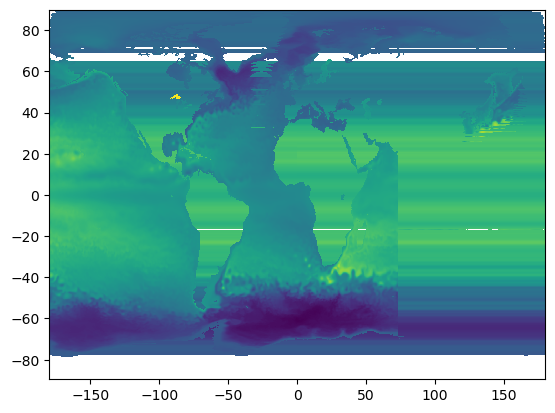

In [7]:
plt.pcolormesh(nemo_t.dataset.ssh[0])

### Some Manipulation

There are currently some basic subsetting routines for Gridded objects, to cut out specified regions of data. Fundamentally, this can be done using xarray’s isel or sel routines to index the data. In this case, the Gridded object will pass arguments straight through to `xarray.isel`.

Lets get the indices of all model points within 111km km of (5W, 55N):

In [8]:
ind_y, ind_x = nemo_t.subset_indices_by_distance(centre_lon=-20, centre_lat=55, radius=500)
#ind_x.shape # uncomment to print data object summary

Now create a new, smaller subsetted Gridded object by passing those indices to `isel`.

In [9]:
ind_y, ind_x = nemo_t.subset_indices_by_distance(centre_lon=-20, centre_lat=55, radius=500)
nemo_t_subset = nemo_t.isel(x_dim=ind_x)
nemo_t_subset.dataset = nemo_t_subset.dataset.rename({'dim_0': 'x_dim'})
nemo_t_subset = nemo_t_subset.isel(y_dim=ind_y)
nemo_t_subset.dataset = nemo_t_subset.dataset.rename({'dim_0': 'y_dim'})

Alternatively, xarray.isel can be applied directly to the `xarray.Dataset` object.
A longitude/latitude box of data can also be extracted using `Gridded.subset_indices()`.

In [10]:
nemo_t_subset.dataset

<xarray.Dataset> Size: 9GB
Dimensions:              (t_dim: 12, axis_nbounds: 2, y_dim: 2533, x_dim: 2533,
                          nvertex: 4, z_dim: 75)
Coordinates:
  * time                 (t_dim) object 96B 1950-01-16 00:00:00 ... 1950-12-1...
    y                    (y_dim) float64 20kB 916.0 916.0 916.0 ... 971.0 971.0
    x                    (x_dim) float64 20kB 1.063e+03 1.064e+03 ... 1.07e+03
    longitude            (y_dim, x_dim) float32 26MB -21.22 -20.96 ... -18.72
    latitude             (y_dim, x_dim) float32 26MB 50.58 50.57 ... 59.43 59.43
    depth_0              (z_dim, y_dim, x_dim) float64 4GB 0.5 0.5 ... 5.791e+03
Dimensions without coordinates: t_dim, axis_nbounds, y_dim, x_dim, nvertex,
                                z_dim
Data variables:
    time_counter_bounds  (t_dim, axis_nbounds) object 192B dask.array<chunksize=(2, 2), meta=np.ndarray>
    bounds_nav_lat       (y_dim, x_dim, nvertex) float32 103MB dask.array<chunksize=(2533, 2533, 2), meta=np.ndarray>
    bounds_nav_lon       (y_dim, x_dim, nvertex) float32 103MB dask.array<chunksize=(2533, 2533, 2), meta=np.ndarray>
    ssh                  (t_dim, y_dim, x_dim) float32 308MB dask.array<chunksize=(2, 2533, 2533), meta=np.ndarray>
    bathymetry           (y_dim, x_dim) float64 51MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    e1                   (y_dim, x_dim) float64 51MB ...
    e2                   (y_dim, x_dim) float64 51MB ...
    e3_0                 (z_dim, y_dim, x_dim) float64 4GB ...
    mask                 (z_dim, y_dim, x_dim) int8 481MB ...
    bottom_level         (y_dim, x_dim) int16 13MB ...
Attributes: (12/35)
    Conventions:            CF-1.10
    experiment_id:          
    branch_method:          micro perturbation (atmosphere stochastic physics...
    parent_variant_label:   r1i1p1f3
    source_index:           HadGEM3-GC31-MM
    frequency:              
    ...                     ...
    title:                  [CANARI] GC3.1 N216 ORCA025 UM11.6
    description:            ocean T grid variables
    source:                 HadGEM3-GC31-MM (2016):\n=aerosol: UKCA-GLOMAP-mo...
    further_info_url:       https://github.com/NCAS-CMS/canari-data
    contact:                
    external_variables:     areacello